In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
%matplotlib inline

In [2]:
from glob import glob
from datetime import datetime
from itertools import *
from operator import itemgetter

In [3]:
spec_files = glob('profiling/*/specs')
spec_files.sort()
specs = [np.genfromtxt(f, delimiter=' ', dtype=int)
         for f in spec_files]

In [4]:
lines = ["-","--","-.",":"]
colors = ('blue','black','red','orange','green','magenta','yellow', 'cyan', 'purple', 'firebrick')
colorcycle = cycle(colors)
lastpe = False
line_def = []
color_def = []
for spec in specs:
    pe, comp, impl, mode = (spec[2], spec[4], spec[5], spec[6])
    if not lastpe or lastpe != pe:
        color = next(colorcycle)
        linecycle = cycle(lines)
    line  = next(linecycle)
    lastpe = pe
    line_def.append(line)
    color_def.append(color)

In [5]:
def set_keys(*indices):
    """Returns a function that returns a tuple of key values"""
    def get_keys(seq, indices=indices):
        keys = []
        for i in indices:
            keys.append(seq[i])
        return tuple(keys)
    return get_keys

In [6]:
def get_average_times(dat, dirCol, stepCol, timeCol):
    dat.sort(order=['dir', 'step'])
    result = {}
    for (c_dir, c_step), rows in groupby(dat, key=set_keys('dir','step')):
        #print c_dir, c_step, rows
        c_dir, c_step, total_time, counter = None, None, 0, 0
        for row in rows:
            if not c_dir:
                c_dir = row[dirCol]
            if not c_step:
                c_step = row[stepCol]
            total_time+=row[timeCol]
            counter += 1
        result.setdefault(c_dir, []).append([c_step, total_time*1.0/counter])
    result2 = []
    for c_dir, rows in result.iteritems():
        inner = []
        for row in rows:
            inner.append(row[1])
        result2.append(inner)
    return np.array([np.array(rows) for rows in result2])

In [7]:
def is_axis(a):
    return not type(a) is np.ndarray

Header = ['timestamp', 'dir', 'step', 'ilp-gen']

In [8]:
def read_result(prefix, name, dtype, data_column, since):
    f = 'profiling/{0}-{1}-results.csv'.format(prefix, name)
    def mkdate(text):
        return datetime.strptime(text, '%Y-%m-%dT%H:%M:%S.%f')
    def mkstep(text):
        return int(text[0:2])
    dat = np.genfromtxt(f, delimiter=',', names=True, dtype=dtype, converters={'timestamp':mkdate, 'step':mkstep})
    if since:
        dat = dat[dat['timestamp'] > since ]
    dat2 = get_average_times(dat, 1, 2, data_column).transpose()
    print 'Loaded {0} records for {1} ({2[0]}x{2[1]} unique) = {3} run(s)'.format(
        len(dat), name, dat2.shape, len(dat)/dat2.size)
    return dat2

In [9]:
def read_gen_result(impl, since = None):
    return read_result('gen', impl, ('datetime64[us]', int, int, float), 3, since)
def read_sol_result(solver, since = None):
    return read_result('sol', solver, ('datetime64[us]', int, int, int, int, int, float, float), 7, since)

Header = ['timestamp', 'dir', 'step', 'rows', 'cols', 'non-zero', 'ilp-sol', 'ti-ilp-sol']

In [13]:
racket_dat  = read_gen_result('plt-r6rs')
larceny_dat = read_gen_result('larceny', since = datetime(2015,6,12,0,0,0))
java_dat    = read_gen_result('java')

Loaded 800 records for plt-r6rs (8x23 unique) = 4 run(s)
Loaded 192 records for larceny (8x23 unique) = 1 run(s)
Loaded 71 records for java (1x23 unique) = 3 run(s)


In [14]:
java_glpk_dat = read_sol_result('java')
glpk_dat      = read_sol_result('glpk')
gurobi_dat    = read_sol_result('gurobi')

Loaded 69 records for java (1x23 unique) = 3 run(s)
Loaded 1656 records for glpk (8x23 unique) = 9 run(s)
Loaded 216 records for gurobi (8x27 unique) = 1 run(s)


In [15]:
START_STEP = 1
MAX_PLOTS_IN_ONE, current_plot, ax_nr, last_res = 6, 0, 0, -1
params = []
for i in xrange(len(specs)):
    current_res = specs[i][2]
    current_plot += 1
    if current_plot > MAX_PLOTS_IN_ONE and last_res != current_res:
        ax_nr += 1
        current_plot = 0
    params.append([ax_nr, racket_dat[START_STEP:,i], larceny_dat[START_STEP:,i],
                   glpk_dat[:,i], gurobi_dat[:,i],
                   line_def[i], color_def[i], '{2:d} x ({4}*{5}*{6})'.format(*specs[i]),
                   java_dat[:,i], java_glpk_dat[:,i]])
    last_res = current_res

## ILP-Re-Generation and Solving Time

- ILP-Re-Generation describes the time it takes for the Scheme implementations to evaluate the attribute computing the ILP
    - it does not include the time to read from and write to disk
    - "Java" denotes the Java- and EMF-based generation
- ILP Solving describes the time it takes the solvers (GLPK and Gurobi in this case) to solve the generated ILP
    - "GLPK (Java)" denotes the time to solve the ILP generated by the Java-based generation with GLPK. Its format was modifiert slightly to be accepted by GLPK, as it was originally generated for lp_solve
    - "GLPK (Scheme)" denotes the time to solve the ILP generated by any scheme implementation with GLPK
- the plots show different system configurations
    - a system configuration is given by "r x ( c \* i \* m )", which describes a system with *r* resources and *c* software components with *i* implementations having *m* modes each.
- for one such configuration the same experiment is run, i.e. the system is modified 7 times leading to the 7 steps, whereas only changes on hardware resources are made
    - for the cases involving Java (both, generation and solving), the same time is used for every step, as the generation always starts from skretch. Further, the changes (e.g. change the value of a single hardware resource while generation) can not be reflected by the Java System Generator
- on the x-axis, the steps of this manipulation are shown
    - the initial generation of the ILP (step zero) is only shown below in numbers, as it would skew the diagrams

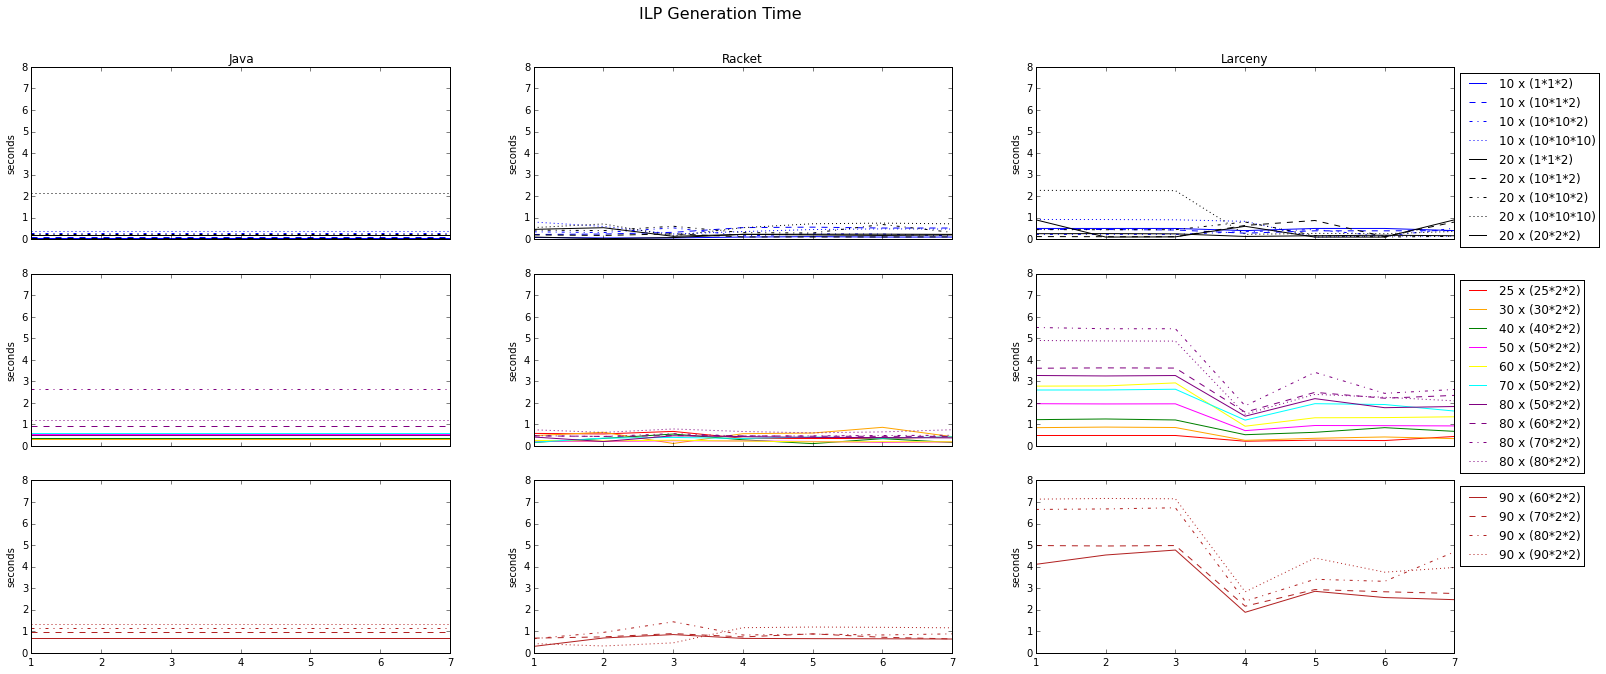

In [16]:
# needed number of axes equals ax_nr+1 now
f, ax_arr = plt.subplots(nrows = ax_nr+1, ncols = 3, sharex=True, sharey=True)
f.set_size_inches(25.5,10.5)
one_plot = ax_arr.shape[1] == 1

lines, labels = [], []
for p in params:
    ax_tup = ax_arr if one_plot else ax_arr[p[0]]
    ax_j = ax_tup[0]
    ax_r = ax_tup[1]
    ax_l = ax_tup[2]
#    x_g = np.array(xrange(1,len(p[1])+1)) # start at one, since first gen-time is cut
    x_g = np.array(xrange(START_STEP,len(p[1])+START_STEP)) # start at zero
    line_java    = ax_j.plot(x_g, p[8][0]*np.ones(len(p[1])), ls = p[5], c = p[6], label = p[7])
    line_racket  = ax_r.plot(x_g, p[1], ls = p[5], c = p[6], label = p[7])
    line_larceny = ax_l.plot(x_g, p[2], ls = p[5], c = p[6], label = p[7])
    ax_l.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_j.set_ylabel('seconds')
    ax_r.set_ylabel('seconds')
    ax_l.set_ylabel('seconds')
    lines.append(line_racket[0])
    labels.append(p[7])

first_ax = ax_arr if one_plot else ax_arr[0]
plt.suptitle('ILP Generation Time', fontsize = 16)
first_ax[0].set_title('Java')
first_ax[1].set_title('Racket')
first_ax[2].set_title('Larceny')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plots.
f.subplots_adjust(hspace=0.2)
plt.setp([a.get_xticklabels() for a in f.axes[:-3]], visible=False)
plt.setp([a.get_yticklabels() for a in f.axes], visible=True)
plt.savefig('gen.pdf')
plt.savefig('gen.png')
plt.show()

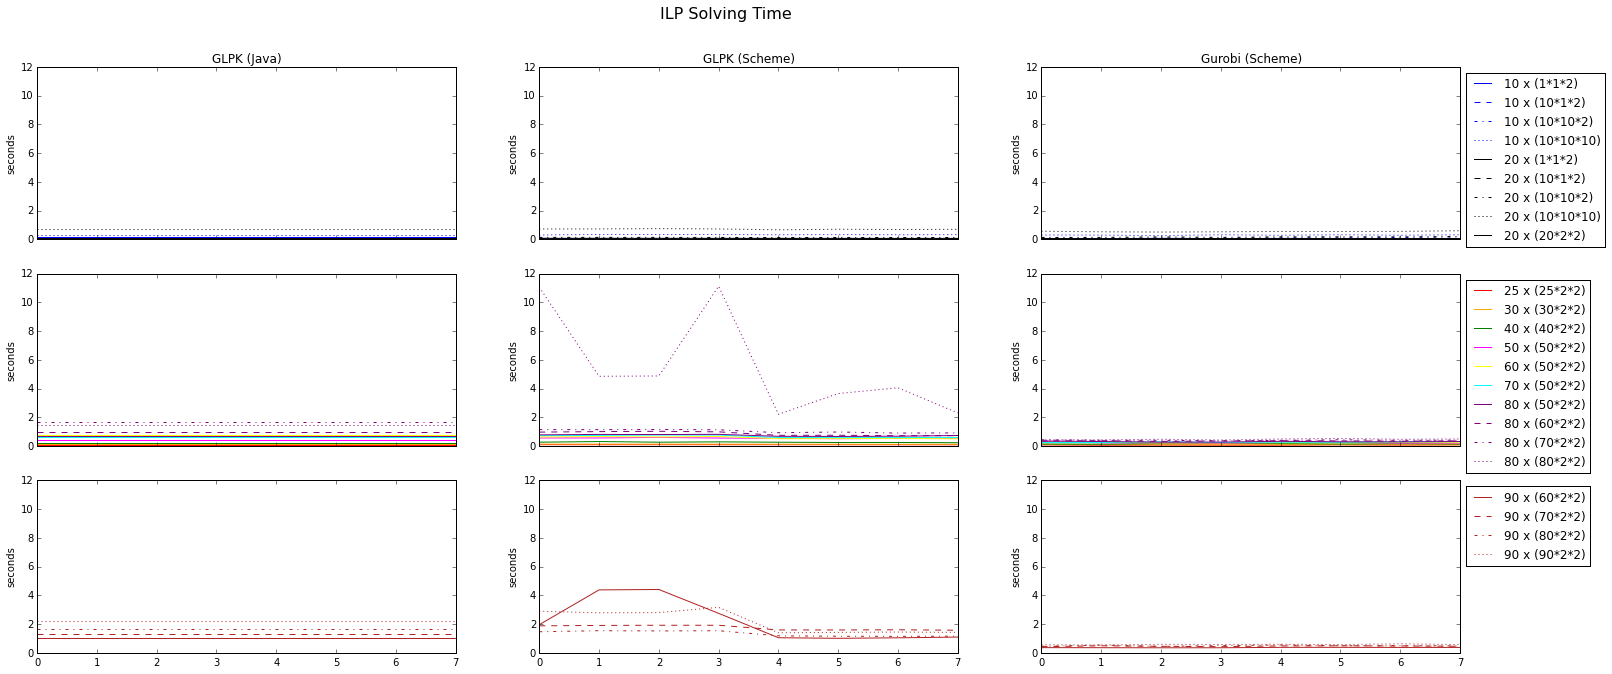

In [17]:
f, ax_arr = plt.subplots(nrows = ax_nr+1, ncols = 3, sharex=True, sharey=True)
f.set_size_inches(25.5,10.5)
one_plot = ax_arr.shape[1] == 1

lines, labels = [], []
for p in params:
    ax_tup = ax_arr if one_plot else ax_arr[p[0]]
    ax_javaglpk = ax_tup[0]
    ax_glpk     = ax_tup[1]
    ax_gurobi   = ax_tup[2]
    x = np.array(xrange(0,len(p[3]))) # start at zero
    line_javaglpk = ax_javaglpk.plot(x, p[9][0]*np.ones(len(p[3])), ls = p[5], c = p[6], label = p[7])
    line_glpk     = ax_glpk.plot(x, p[3], ls = p[5], c = p[6], label = p[7])
    line_gurobi   = ax_gurobi.plot(x, p[4], ls = p[5], c = p[6], label = p[7])
    ax_gurobi.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_javaglpk.set_ylabel('seconds')
    ax_glpk.set_ylabel('seconds')
    ax_gurobi.set_ylabel('seconds')
    lines.append(line_glpk[0])
    labels.append(p[7])

first_ax = ax_arr if one_plot else ax_arr[0]
plt.suptitle('ILP Solving Time', fontsize = 16)
first_ax[0].set_title('GLPK (Java)')
first_ax[1].set_title('GLPK (Scheme)')
first_ax[2].set_title('Gurobi (Scheme)')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plots.
f.subplots_adjust(hspace=0.2)
plt.setp([a.get_xticklabels() for a in f.axes[:-3]], visible=False)
plt.setp([a.get_yticklabels() for a in f.axes], visible=True)
plt.savefig('sol.pdf')
plt.savefig('sol.png')
plt.show()

## Times for initial generation of the ILP

In [18]:
(racket_dat[0], larceny_dat[0])

(array([  0.434     ,   0.1638    ,   1.91333333,  10.98416667,
          0.4675    ,   0.3015    ,   3.519     ,  22.77425   ,
          1.28425   ,   2.2165    ,   3.19425   ,   6.043     ,
         10.5105    ,  12.0355    ,  15.2275    ,  16.9825    ,
         21.168     ,  25.59175   ,  27.72366667,  27.22525   ,
         29.74875   ,  36.94825   ,  42.6945    ]),
 array([  0.17 ,   0.187,   1.766,  11.3  ,   0.3  ,   0.403,   3.304,
         22.73 ,   1.439,   2.375,   3.521,   6.308,  10.359,  12.319,
         15.182,  18.13 ,  21.917,  27.992,  32.143,  25.217,  30.606,
         38.144,  45.88 ]))